#Reference
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1wTMIrJhYsQdq_u7ROOkf0Lu_fsX5Mu8a)

- 현제 이 노트북은 Hands 데이터를 기반으로 작성되었음 
- roboflow의 tfrecrod 형식 데이터를 사용하면 그대로 사용 가능 

## Configs and Hyperparameters

- 다양한 모델을 지원하며 이 노트북에서는 ssd_mobilenet_v2를 사용할 것임 

In [1]:
# If you forked the repo, you can replace the link.
repo_url = 'https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn'

# Number of training steps - 1000 will train very quickly, but more steps will increase accuracy.
num_steps = 30000  # 200000 to improve

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    },    
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

In [2]:
# 여기서 사용하는 Tensorflow Object Detection API는 Tensorflow 2 이상의 버전은 지원하지 않으므로 낮은 버전의 TF 사용 
%tensorflow_version 1.x

TensorFlow 1.x selected.


\## Clone the `tensorflow-object-detection` repository or your fork.

In [3]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'tensorflow-object-detection-faster-rcnn'...
remote: Enumerating objects: 885, done.
remote: Total 885 (delta 0), reused 0 (delta 0), pack-reused 885
Receiving objects: 100% (885/885), 24.83 MiB | 24.20 MiB/s, done.
Resolving deltas: 100% (428/428), done.
/content/tensorflow-object-detection-faster-rcnn
Already up to date.


## Install required packages

In [4]:
from IPython.display import clear_output
%tensorflow_version 1.x
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git
!pip install tensorflow.io
!pip install tf_slim

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

!pip install lvis

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!pip install numpy==1.19.5
!pip uninstall -y pycocotools
!pip install pycocotools --no-binary pycocotools

!python object_detection/builders/model_builder_test.py
clear_output()

## 데이터 로드 
- 앞선 Roboflow 사이트에서 만든 데이터 셋을 여기서 다운 받음 
- Raw URL 링크를 이용해 데이터를 다운 받음 

In [5]:
#아래 roboflow_dataset 자신의 roboflow 링크로 바꾸면 됨 
%cd /content/tensorflow-object-detection-faster-rcnn/data
roboflow_dataset = "https://public.roboflow.com/ds/GqIbJzmqlv?key=9vgvnt3ROI"
!curl -L {roboflow_dataset} > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content/tensorflow-object-detection-faster-rcnn/data
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   4571      0 --:--:-- --:--:-- --:--:--  4571
100  316M  100  316M    0     0   121M      0  0:00:02  0:00:02 --:--:--  150M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/hands.tfrecord     
 extracting: test/hands_label_map.pbtxt  
   creating: train/
 extracting: train/hands.tfrecord    
 extracting: train/hands_label_map.pbtxt  
   creating: valid/
 extracting: valid/hands.tfrecord    
 extracting: valid/hands_label_map.pbtxt  


In [6]:
# training set
%ls train

hands_label_map.pbtxt  hands.tfrecord


In [7]:
# test set
%ls test

hands_label_map.pbtxt  hands.tfrecord


In [8]:
# NOTE: Update these TFRecord names from "cells" and "cells_label_map" to your files!
# 각 이름 확인 
from glob import glob
test_record_fname = glob(os.path.join(os.getcwd(),'test','*.tfrecord'))[0]
train_record_fname = glob(os.path.join(os.getcwd(),'train','*.tfrecord'))[0]
label_map_pbtxt_fname = glob(os.path.join(os.getcwd(),'train','*.pbtxt'))[0]
print(train_record_fname,'\n',test_record_fname,'\n',label_map_pbtxt_fname)

/content/tensorflow-object-detection-faster-rcnn/data/train/hands.tfrecord 
 /content/tensorflow-object-detection-faster-rcnn/data/test/hands.tfrecord 
 /content/tensorflow-object-detection-faster-rcnn/data/train/hands_label_map.pbtxt


## Download base model

In [9]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [10]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 23 root   root  4.0K Jul  1 11:46 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


In [11]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [12]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)
print(pipeline_fname)

/content/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config


In [13]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [14]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [ ]:
!cat {pipeline_fname}

In [15]:
model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

## Train the model

- 0618 17:37:26.270975 140058044225408 basic_session_run_hooks.py:262] loss = 133.47752, step = 0
- 위와 같이 log가 뜨면 학습이 성공적으로 진행되고 있다는 의미 

In [ ]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

In [ ]:
!ls {model_dir}

### 만약 다음 에러가 나타날 경우 (Optional)
```
TypeError: Signature mismatch. Keys must be dtype <dtype: 'float32'>, got <dtype: 'string'>.
```

- '/content/tensorflow-object-detection-faster-rcnn/data/train 디렉토리에 있는 .pbtxt 파일을 수정 하거나 아래 코드 실행을 통해 파일 수정이 필요 

- 직접 수정하는 경우 해당 파일을 더블 클릭 하고 아래 내용 추가 
```
item {
    name: "cup",
    id: 1,
    display_name: "myleft"
}
```

In [ ]:
#코드로 파일 수정하는 경우 
content = 'item {\n  name: "cup",\n  id: 1,\n  display_name: "myleft"\n}'

for i in ['train','test','valid']:
  pbtxt_path = f'/content/tensorflow-object-detection-faster-rcnn/data/{i}'
  pbtxt_file = glob.glob(os.path.join(pbtxt_path,'*.pbtxt'))[0]
  with open(pbtxt_file,'w') as f:
    f.write(content)

## 학습 모델 weigths 추출 
- ./model/research/fine_tuned_model/saved_model/saved_model.pb 로 모델 weights 파일 저장 

In [ ]:
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

In [20]:
!zip -r saved_model.zip /content/models/research/fine_tuned_model

  adding: content/models/research/fine_tuned_model/ (stored 0%)
  adding: content/models/research/fine_tuned_model/pipeline.config (deflated 70%)
  adding: content/models/research/fine_tuned_model/frozen_inference_graph.pb (deflated 10%)
  adding: content/models/research/fine_tuned_model/saved_model/ (stored 0%)
  adding: content/models/research/fine_tuned_model/saved_model/saved_model.pb (deflated 10%)
  adding: content/models/research/fine_tuned_model/saved_model/variables/ (stored 0%)
  adding: content/models/research/fine_tuned_model/model.ckpt.meta (deflated 93%)
  adding: content/models/research/fine_tuned_model/model.ckpt.index (deflated 68%)
  adding: content/models/research/fine_tuned_model/checkpoint (deflated 42%)
  adding: content/models/research/fine_tuned_model/model.ckpt.data-00000-of-00001 (deflated 7%)


In [ ]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


## 다운로드 .pb 파일 

In [21]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)
!ls -alh {pb_fname}

-rw-r--r-- 1 root root 19M Jul  1 14:18 /content/models/research/fine_tuned_model/frozen_inference_graph.pb


In [22]:
from google.colab import files
files.download(pb_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Run inference test
- 학습한 모델로 추론을 하기 위해서는 새로운 이미지를 다운 받아야 함 


## Test 이미지 다운로드

In [ ]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

#수정해야 하는 것 
#sample_img 와 file_name을 바꾸어야 함 
PATH_TO_TEST_IMAGES_DIR =  repo_dir_path + "/data/test/"
sample_img = 'https://images.unsplash.com/photo-1556484687-30636164638b?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxzZWFyY2h8Mnx8bWFueSUyMGhhbmRzfGVufDB8fDB8fA%3D%3D&w=1000&q=80' #<--- 새로운 이미지 다운 링크로 변경 필요 
file_name = 'hands.jpg'

import urllib.request
urllib.request.urlretrieve(sample_img, 
                           PATH_TO_TEST_IMAGES_DIR + file_name)


assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.jpg"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/tensorflow-object-detection-faster-rcnn/data/test/hands.jpg']


## 모듈 세팅 

In [ ]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

/content/models/research/object_detection


In [ ]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [ ]:
# This is needed to display the images.
%matplotlib inline

In [ ]:
TEST_IMAGE_PATHS = glob.glob('/content/tensorflow-object-detection-faster-rcnn/data/test/*.jpg')

/content/tensorflow-object-detection-faster-rcnn/data/test/hands.jpg


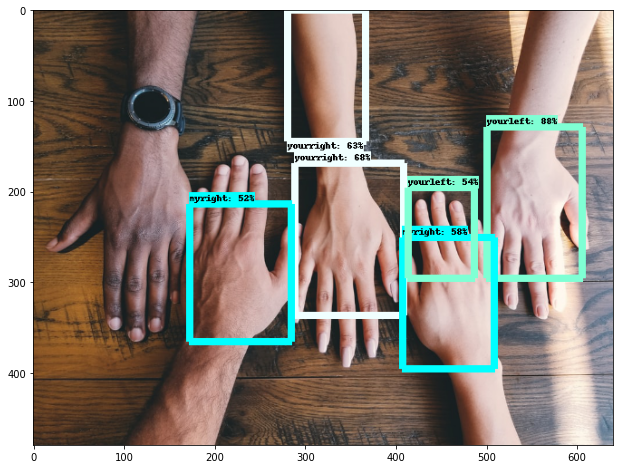

In [ ]:
import cv2 
for image_path in TEST_IMAGE_PATHS:
  try:
    image = Image.open(image_path)
    print(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    image_np = cv2.resize(image_np,dsize=(640,480))
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    plt.show()
  except Exception:
    pass

#모델 weights 변환 
- 우리가 필요한 것은 tfjs 형태의 weights 파일이기 때문에 .pb 파일을 tfjs형태로 변환 함 

In [ ]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [ ]:
!ls -alh {pb_fname}

-rw-r--r-- 1 root root 19M Jun 17 02:21 /content/models/research/fine_tuned_model/frozen_inference_graph.pb


In [ ]:
!pip install tensorflowjs

In [ ]:
%cd /content/
%mkdir ./model
!tensorflowjs_converter \
    --input_format=tf_frozen_model \
    --output_node_names='detection_boxes,detection_classes,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' \
    --saved_model_tags=serve \
    /content/models/research/fine_tuned_model/frozen_inference_graph.pb \
    /content/model/

/content
Writing weight file /content/model/model.json...


#모델 다운로드 
- 마운트 한 자기 구글 드라이브로 이동 

In [ ]:
!cp -r /content/model /content/drive/MyDrive